In [2]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd
import contextily as cx
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import root_mean_squared_error
import xgboost as xgb
import pickle
import openmeteo_requests
from retry_requests import retry
import requests_cache

In [3]:
hotspots = gpd.read_file("./data_2024/hotspots/fire_archive_M-C61_629919.shp")
perimeter = gpd.read_file("./data_2024/perimeter/cc_apt_buf.shp")

# print(hotspots.head(3))
# print(perimeter.head(3))


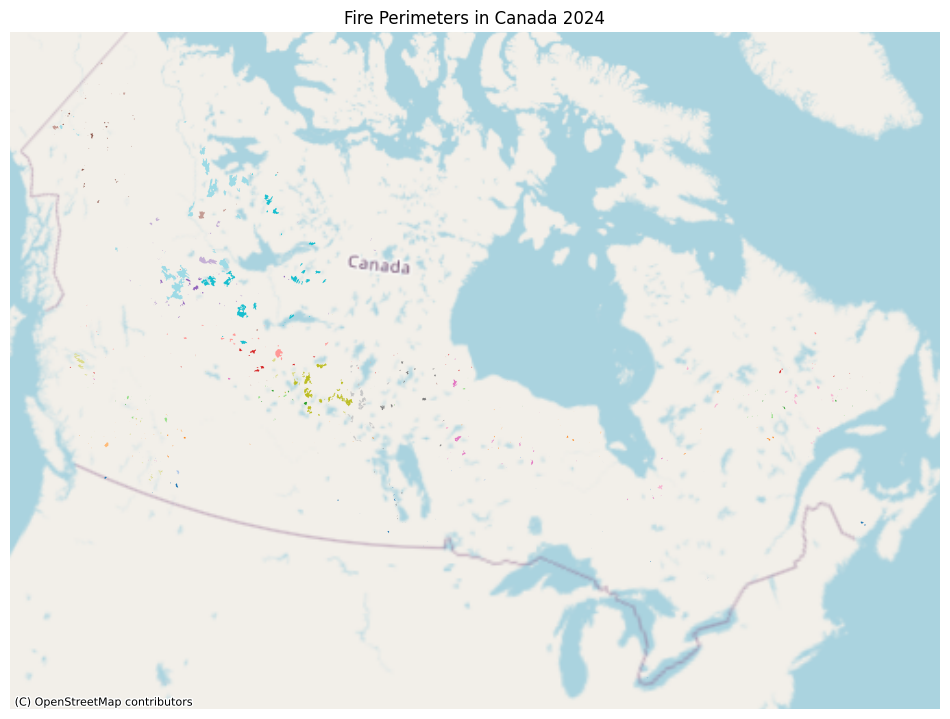

In [4]:
# Set + Match CRS for both files
if hotspots.crs is None:
    hotspots.set_crs(epsg=4326, inplace=True)  # WGS84 lat/lon

if perimeter.crs is None:
    perimeter.set_crs(epsg=3978, inplace=True)  # NAD_1983_Canada_Atlas_Lambert

hotspots = hotspots.to_crs(perimeter.crs)

# Check intersections and join hotspots and perimeters into 1 dataframe
hotspots_with_perimeter = gpd.sjoin(hotspots, perimeter, how="inner", predicate="intersects")

# combined ACQ_TIME + ACQ_DATE
hotspots_with_perimeter['ACQ_TIME'] = hotspots_with_perimeter['ACQ_TIME'].astype(str).str.zfill(4)
hotspots_with_perimeter['ACQ_DATETIME'] = pd.to_datetime(
    hotspots_with_perimeter['ACQ_DATE'].astype(str) + ' ' +
    hotspots_with_perimeter['ACQ_TIME'].str[:2] + ':' +
    hotspots_with_perimeter['ACQ_TIME'].str[2:], 
    format='%Y-%m-%d %H:%M'
)

# Align hotspot aquired date, with the perimeter start + end dates
hotspots_with_perimeter = hotspots_with_perimeter[
    (hotspots_with_perimeter['ACQ_DATETIME'] >= hotspots_with_perimeter['FIRSTDATE']) &
    (hotspots_with_perimeter['ACQ_DATETIME'] <= hotspots_with_perimeter['LASTDATE'])
]

# print(hotspots_with_perimeter.head())

# Count number of fire points per polygon UID
counts = hotspots_with_perimeter.groupby("UID").size().reset_index(name="hotspot_count")

# add a hotspot_count column for keeping track of how many hotspots there are per fire
perimeter_with_counts = perimeter.merge(counts, on="UID", how="left")
perimeter_with_counts["hotspot_count"] = perimeter_with_counts["hotspot_count"].fillna(0).astype(int)

# Plot fire perimeters colored by UID
fig, ax = plt.subplots(figsize=(12, 12))
perimeter_with_counts.plot(
    ax=ax,
    column="UID",
    categorical=True,
    legend=False,
    cmap="tab20"
)
# set map as background
cx.add_basemap(ax, crs=perimeter_with_counts.crs, source=cx.providers.OpenStreetMap.Mapnik)

ax.set_title("Fire Perimeters in Canada 2024")
ax.axis("off")
plt.show()

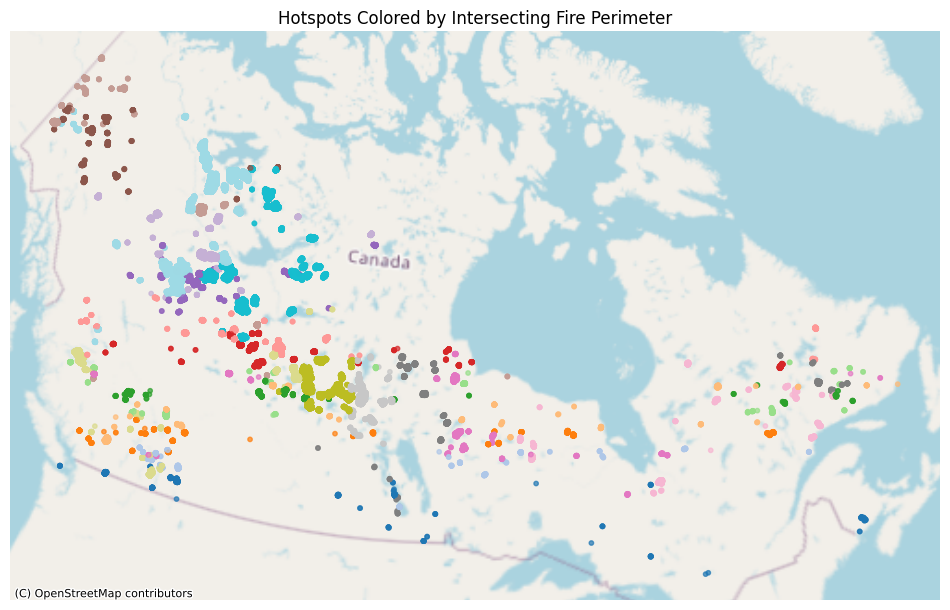

In [5]:
# Plot hotspot points, colored by respective fire groups (determined by intersection)
fig, ax = plt.subplots(figsize=(12, 12))

hotspots_with_perimeter.plot(
    ax=ax,
    column="UID",
    categorical=True,
    legend=False,
    cmap="tab20",
    markersize=10,
    alpha=0.7
)

ax.set_title("Hotspots Colored by Intersecting Fire Perimeter")
ax.axis("off")
cx.add_basemap(ax, crs=perimeter_with_counts.crs, source=cx.providers.OpenStreetMap.Mapnik)
plt.show()

In [6]:
training_data = hotspots_with_perimeter[['LATITUDE', 'LONGITUDE', 'BRIGHTNESS', 'ACQ_DATE', 'ACQ_TIME', 
                                         'FRP', 'UID', 'HCOUNT', 'AREA', 'FIRSTDATE', 'LASTDATE']]

training_data = training_data[training_data['UID'].map(training_data['UID'].value_counts()) > 2]

grouped = training_data.groupby(['UID', 'ACQ_DATE'])

def max_and_min(g):
    max_lat_row = g.loc[g['LATITUDE'].idxmax()]
    min_lat_row = g.loc[g['LATITUDE'].idxmin()]
    max_lon_row = g.loc[g['LONGITUDE'].idxmax()]
    min_lon_row = g.loc[g['LONGITUDE'].idxmin()]
    
    return pd.Series({
        'LAT_MAX_LAT': max_lat_row['LATITUDE'],
        'LAT_MAX_LON': max_lat_row['LONGITUDE'],
        'LAT_MIN_LAT': min_lat_row['LATITUDE'],
        'LAT_MIN_LON': min_lat_row['LONGITUDE'],
        'LON_MAX_LAT': max_lon_row['LATITUDE'],
        'LON_MAX_LON': max_lon_row['LONGITUDE'],
        'LON_MIN_LAT': min_lon_row['LATITUDE'],
        'LON_MIN_LON': min_lon_row['LONGITUDE'],
        'ACQ_TIME_MAX_LAT': max_lat_row['ACQ_TIME'],
        'ACQ_TIME_MIN_LAT': min_lat_row['ACQ_TIME'],
        'ACQ_TIME_MAX_LON': max_lon_row['ACQ_TIME'],
        'ACQ_TIME_MIN_LON': min_lat_row['ACQ_TIME']
    })

training_data = grouped.apply(max_and_min).reset_index()

# add column for next lon/lat
training_data['NEXT_LAT_MAX_LAT'] = training_data.groupby('UID')['LAT_MAX_LAT'].shift(-1)
training_data['NEXT_LAT_MAX_LON'] = training_data.groupby('UID')['LAT_MAX_LON'].shift(-1)
training_data['NEXT_LAT_MIN_LAT'] = training_data.groupby('UID')['LAT_MIN_LAT'].shift(-1)
training_data['NEXT_LAT_MIN_LON'] = training_data.groupby('UID')['LAT_MIN_LON'].shift(-1)
training_data['NEXT_LON_MAX_LAT'] = training_data.groupby('UID')['LON_MAX_LAT'].shift(-1)
training_data['NEXT_LON_MAX_LON'] = training_data.groupby('UID')['LON_MAX_LON'].shift(-1)
training_data['NEXT_LON_MIN_LAT'] = training_data.groupby('UID')['LON_MIN_LAT'].shift(-1)
training_data['NEXT_LON_MIN_LON'] = training_data.groupby('UID')['LON_MIN_LON'].shift(-1)
training_data = training_data.dropna(subset=['NEXT_LAT_MAX_LAT', 'NEXT_LAT_MAX_LON', 
                                             'NEXT_LAT_MIN_LAT', 'NEXT_LAT_MIN_LON',
                                             'NEXT_LON_MAX_LAT', 'NEXT_LON_MAX_LON',
                                             'NEXT_LON_MIN_LAT', 'NEXT_LON_MIN_LON'])

C:\Users\geoff\AppData\Local\Temp\ipykernel_2544\1595593627.py:29: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  training_data = grouped.apply(max_and_min).reset_index()


In [17]:
# Add weather data to table
cache_session = requests_cache.CachedSession('.cache', expire_after = -1)
retry_session = retry(cache_session, retries = 5, backoff_factor = 0.2)
openmeteo = openmeteo_requests.Client(session = retry_session)

points = ['LAT_MAX', 'LAT_MIN', 'LON_MAX', 'LON_MIN']
weather_features = ['temperature_2m', 'relative_humidity_2m', 'wind_speed_10m', 'wind_direction_10m', 'precipitation']
weather_columns = [f"{pt}_{feat}" for pt in points for feat in weather_features]

# add new columns to training_data
for col in weather_columns:
    training_data[col] = None

for index, row in training_data.iterrows():
    lat_list = [row.get(f"{pt}_LAT") for pt in points]
    lon_list = [row.get(f"{pt}_LON") for pt in points]
    date = pd.to_datetime(row["ACQ_DATE"]).strftime("%Y-%m-%d")

    url = "https://archive-api.open-meteo.com/v1/archive"
    params = {
        "latitude": lat_list,
        "longitude": lon_list,
        "start_date": [date, date, date, date],
        "end_date": [date, date, date, date],
        "hourly": "temperature_2m,relative_humidity_2m,wind_speed_10m,wind_direction_10m,precipitation",
        "timezone": ["GMT", "GMT", "GMT", "GMT"]
    }
    response = openmeteo.weather_api(url, params=params)

    acq_time_map = {
        "LAT_MAX": "ACQ_TIME_MAX_LAT",
        "LAT_MIN": "ACQ_TIME_MIN_LAT",
        "LON_MAX": "ACQ_TIME_MAX_LON",
        "LON_MIN": "ACQ_TIME_MIN_LON"
    }

    for i, point in enumerate(points):
        weather_data = response[i].Hourly()
        acq_col = acq_time_map[point]
        current_time = int(str(row[acq_col]).zfill(4)[:2])

        values = {
            "temperature_2m" : weather_data.Variables(0).ValuesAsNumpy()[current_time],
            "relative_humidity_2m" : weather_data.Variables(1).ValuesAsNumpy()[current_time],
            "wind_speed_10m" : weather_data.Variables(2).ValuesAsNumpy()[current_time],
            "wind_direction_10m" : weather_data.Variables(3).ValuesAsNumpy()[current_time],
            "precipitation" : weather_data.Variables(4).ValuesAsNumpy()[current_time]
        }

        for stat, val in values.items():
            training_data.at[index, f"{point}_{stat}"] = val
        
        # training_data.at[index, "relative_humidity_2m"] = relative_humidity_2m
        # training_data.at[index, "wind_speed_10m"] = wind_speed_10m
        # training_data.at[index, "wind_direction_10m"] = wind_direction_10m
        # training_data.at[index, "precipitation"] = precipitation
    print(f"{index} done")

print(training_data.head())

#----------------------------------------------------------------------------------------
# first_row = training_data.iloc[-1]

# # lat = first_row["LATITUDE"]
# # lon = first_row["LONGITUDE"]
# lat_list = [first_row.get(f"{pt}_LAT") for pt in points]
# lon_list = [first_row.get(f"{pt}_LON") for pt in points]
# date = pd.to_datetime(first_row["ACQ_DATE"]).strftime("%Y-%m-%d")

# url = "https://archive-api.open-meteo.com/v1/archive"
# params = {
# 	"latitude": lat_list,
# 	"longitude": lon_list,
# 	"start_date": date,
# 	"end_date": date,
# 	"hourly": "temperature_2m,relative_humidity_2m,wind_speed_10m,wind_direction_10m,precipitation",
# 	"timezone": "UTC"
# }
# acq_time_map = {
#     "LAT_MAX": "ACQ_TIME_MAX_LAT",
#     "LAT_MIN": "ACQ_TIME_MIN_LAT",
#     "LON_MAX": "ACQ_TIME_MAX_LON",
#     "LON_MIN": "ACQ_TIME_MIN_LON"
# }
# response = openmeteo.weather_api(url, params=params)
# weather = response[0]

# weather_data = weather.Hourly()

# response = openmeteo.weather_api(url, params=params)

# actual_index = training_data.index[-1]
# for i, point in enumerate(points):
#     weather_data = response[i].Hourly()
#     acq_col = acq_time_map[point]
#     current_time = int(str(first_row[acq_col]).zfill(4)[:2])

#     values = {
#         "temperature_2m" : weather_data.Variables(0).ValuesAsNumpy()[current_time],
#         "relative_humidity_2m" : weather_data.Variables(1).ValuesAsNumpy()[current_time],
#         "wind_speed_10m" : weather_data.Variables(2).ValuesAsNumpy()[current_time],
#         "wind_direction_10m" : weather_data.Variables(3).ValuesAsNumpy()[current_time],
#         "precipitation" : weather_data.Variables(4).ValuesAsNumpy()[current_time]
#     }

#     for stat, val in values.items():
#         training_data.at[actual_index, f"{point}_{stat}"] = val

# # training_data.at[index, "relative_humidity_2m"] = relative_humidity_2m
# # training_data.at[index, "wind_speed_10m"] = wind_speed_10m
# # training_data.at[index, "wind_direction_10m"] = wind_direction_10m
# # training_data.at[index, "precipitation"] = precipitation


# print(training_data)

#32269507 


0 done
1 done
3 done
4 done
5 done
6 done
7 done
9 done
11 done
13 done
14 done
16 done
17 done
18 done
19 done
20 done
22 done
24 done
25 done
27 done
28 done
29 done
30 done
31 done
32 done
33 done
35 done
36 done
37 done
38 done
39 done
40 done
41 done
44 done
45 done
46 done
47 done
48 done
49 done
50 done
51 done
52 done
53 done
54 done
55 done
56 done
57 done
59 done
61 done
62 done
63 done
64 done
65 done
66 done
67 done
68 done
69 done
70 done
71 done
72 done
73 done
74 done
75 done
76 done
77 done
79 done
80 done
81 done
82 done
83 done
84 done
85 done
86 done
87 done
88 done
89 done
90 done
91 done
92 done
93 done
94 done
95 done
96 done
97 done
99 done
100 done
101 done
103 done
105 done
107 done
109 done
110 done
111 done
112 done
114 done
115 done
116 done
117 done
119 done
120 done
121 done
122 done
123 done
125 done
126 done
127 done
128 done
129 done
130 done
132 done
135 done
136 done
138 done
139 done
140 done
141 done
142 done
144 done
145 done
146 done
148 done
149 

OpenMeteoRequestsError: {'reason': 'Minutely API request limit exceeded. Please try again in one minute.', 'error': True}

In [ ]:
print(training_data.head())
print(training_data["ACQ_TIME"])

        UID   ACQ_DATE  LAT_MAX_LAT  LAT_MAX_LON  LAT_MIN_LAT  LAT_MIN_LON  \
0  32267271 2024-08-05      47.3180     -80.8734      47.3180     -80.8734   
1  32267271 2024-08-09      47.3432     -80.8781      47.3332     -80.8737   
3  32267297 2024-05-13      49.1239     -96.8370      49.1239     -96.8370   
4  32267297 2024-07-11      49.1201     -96.8333      49.1201     -96.8333   
5  32267297 2024-07-30      49.1196     -96.8336      49.1177     -96.8471   

   LON_MAX_LAT  LON_MAX_LON  LON_MIN_LAT  LON_MIN_LON  ...  \
0      47.3180     -80.8734      47.3180     -80.8734  ...   
1      47.3367     -80.8562      47.3432     -80.8781  ...   
3      49.1239     -96.8370      49.1239     -96.8370  ...   
4      49.1201     -96.8333      49.1201     -96.8333  ...   
5      49.1196     -96.8336      49.1177     -96.8471  ...   

  LON_MAX_temperature_2m LON_MAX_relative_humidity_2m LON_MAX_wind_speed_10m  \
0                21.9555                    37.012165              12.313894  

KeyError: 'ACQ_TIME'

In [ ]:

feature_cols = ['LAT_MAX_LAT', 'LAT_MAX_LON', 'LAT_MIN_LAT', 'LAT_MIN_LON', 'LON_MAX_LAT', 'LON_MAX_LON', 'LON_MIN_LAT', 'LON_MIN_LON']
X = training_data[feature_cols]
y = training_data[['NEXT_LAT_MAX_LAT', 'NEXT_LAT_MAX_LON', 'NEXT_LAT_MIN_LAT', 'NEXT_LAT_MIN_LON',
                   'NEXT_LON_MAX_LAT', 'NEXT_LON_MAX_LON', 'NEXT_LON_MIN_LAT', 'NEXT_LON_MIN_LON']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model = MultiOutputRegressor(xgb.XGBRegressor(objective='reg:squarederror', random_state=42))
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# # Evaluate RMSE for each output
# for i, col in enumerate(y.columns):
#     rmse = root_mean_squared_error(y_test.iloc[:, i], y_pred[:, i])
#     print(f"RMSE for {col}: {rmse:.4f}")

# #PREDICTION TEST HERE ______________________________________________________________________________________
# uid_value = 32269507 # this has the largest amount of hotspots
# matching_rows = training_data[training_data['UID'] == uid_value]
# # print(matching_rows)

# feature_cols = ['LAT_MAX_LAT', 'LAT_MAX_LON', 'LAT_MIN_LAT', 'LAT_MIN_LON', 'LON_MAX_LAT', 'LON_MAX_LON', 'LON_MIN_LAT', 'LON_MIN_LON']
# X_uid = matching_rows[feature_cols]

# # Predict next day max + min, lat + lon
# y_pred = model.predict(X_uid)

# # Add predicted columns to DataFrame
# matching_rows['PRED_NEXT_LAT_MAX_LAT'] = y_pred[:, 0]
# matching_rows['PRED_NEXT_LAT_MAX_LON'] = y_pred[:, 1]
# matching_rows['PRED_NEXT_LAT_MIN_LAT'] = y_pred[:, 2]
# matching_rows['PRED_NEXT_LAT_MIN_LON'] = y_pred[:, 3]
# matching_rows['PRED_NEXT_LON_MAX_LAT'] = y_pred[:, 4]
# matching_rows['PRED_NEXT_LON_MAX_LON'] = y_pred[:, 5]
# matching_rows['PRED_NEXT_LON_MIN_LAT'] = y_pred[:, 6]
# matching_rows['PRED_NEXT_LON_MIN_LON'] = y_pred[:, 7]

# print(matching_rows.head())


In [ ]:
# pickle.dump(model, open("spread_model.pkl", "wb"))